In [34]:
import sys
from pathlib import Path
# Get the repository root (1 levels up from current notebook)
repo_root = Path(__file__).parent.parent if '__file__' in globals() else Path.cwd().parent
sys.path.insert(0, str(repo_root))

# import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, mean_absolute_error, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
import Template
# Definición de modulos
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling  import SMOTE, ADASYN
from sklearn.decomposition import PCA

# Instantiate the Template class
Template = Template.Template()

# Build the path to the Excel file in the repository root
data_path = os.path.join(repo_root, 'Datos1_InteraccionesNIR_clear.xlsx')
# import the data from all sheets of the Excel file


df6, df7, df8, df12, df13, df14 = [
    pd.read_excel(data_path, sheet_name=i) for i in range(6)
]


df_concatenation = pd.concat([df6, df7, df8, df12, df13, df14], ignore_index=True)

In [35]:
RefDf = df6[(df6['Tratamiento'] == 'Control')]

# Extract the relevant columns (from column 2 onwards)
data_cols = RefDf.iloc[:, 2:]

# The reference value is the mean of RefDf for each wavelength
REF = data_cols.mean()

REF.head()

350    0.076370
351    0.075999
352    0.072463
353    0.073760
354    0.074611
dtype: float64

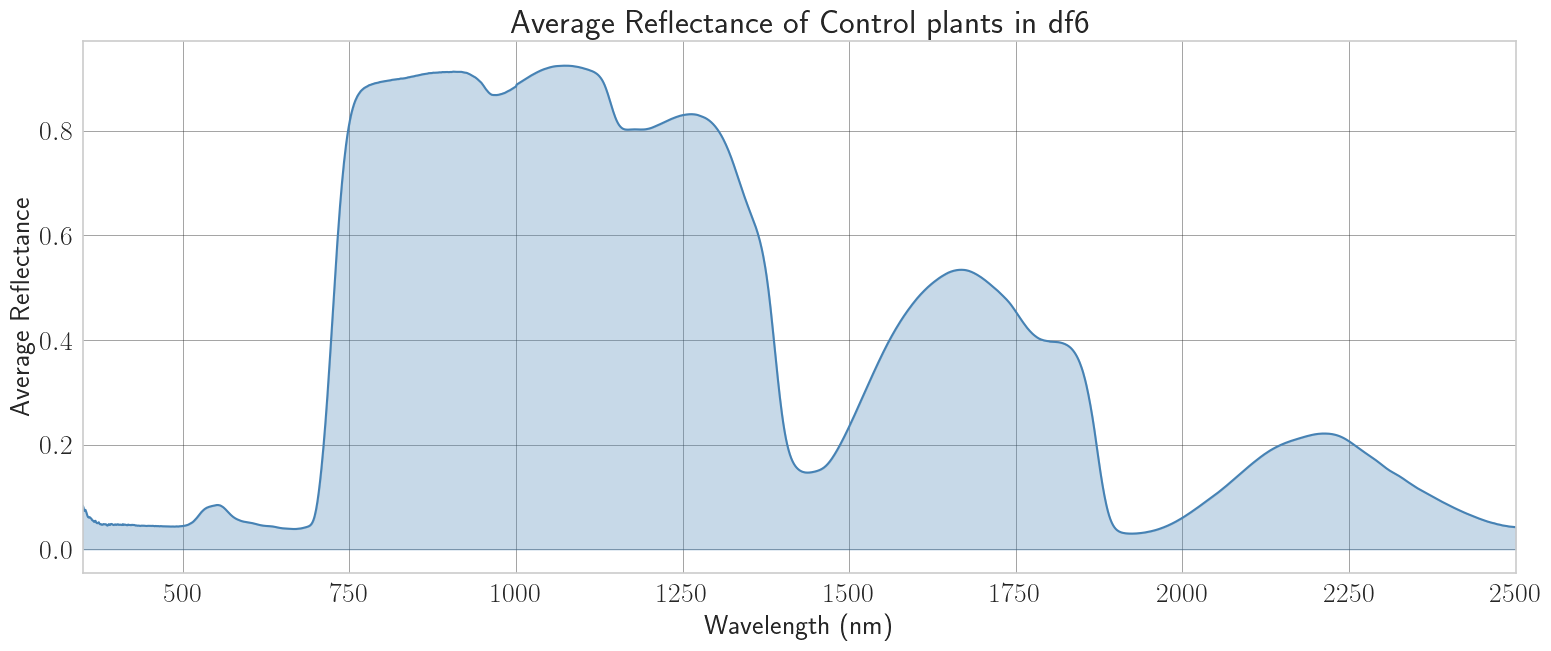

In [36]:
wavelengths = RefDf.columns[2:].astype(float)
magnitudes_values = RefDf.iloc[0, 2:].values.astype(float)
 
# Plot 1: Line plot of magnitudes across wavelengths
plt.figure(figsize=(16, 7))
plt.plot(wavelengths, magnitudes_values, linewidth=1.5, color='steelblue')
plt.fill_between(wavelengths, magnitudes_values, alpha=0.3, color='steelblue')
plt.xlabel('Wavelength (nm)', fontsize=20)
plt.ylabel('Average Reflectance', fontsize=20)
plt.title('Average Reflectance of Control plants in df6', fontsize=24, fontweight='bold')
plt.grid(True, alpha=0.5)
plt.xlim(wavelengths.min(), wavelengths.max())
plt.tight_layout()
plt.show()

## Cambio relativo respecto a la referencia

In [37]:
all_magnitudes = []

for treatment in df_concatenation['Tratamiento'].unique():
    df_treat = df_concatenation[df_concatenation['Tratamiento'] == treatment]
    for plant_num in df_treat['Planta'].unique():
        df_plant = df_treat[df_treat['Planta'] == plant_num]
        
        # Extract the relevant columns (from column 2 onwards)
        data_cols = df_plant.iloc[:, 2:]

        # Calculate the magnitude for each column
        magnitudes = []

        for col in data_cols.columns:
            # Get the column values
            values = data_cols[col].values
            
            # Get the reference value from REF for this wavelength
            REF_value = REF[col]
            
            # Calculate |y-REF|/REF, |z-REF|/REF, etc. for all values
            if REF_value != 0:  # Avoid division by zero
                differences = np.abs(values - REF_value) / REF_value
                # Calculate the magnitude (Euclidean norm)
                magnitude = np.sqrt(np.sum(differences**2))
            else:
                magnitude = np.nan  # Handle zero reference value
            
            magnitudes.append(magnitude)

        # Create a row with treatment and plant info plus magnitudes
        row_data = {'Tratamiento': treatment, 'Planta': plant_num}
        row_data.update({col: mag for col, mag in zip(data_cols.columns, magnitudes)})
        
        all_magnitudes.append(row_data)

# Create the final dataframe with all magnitudes
df_all_magnitudes = pd.DataFrame(all_magnitudes)

# Display the result
print(f"Final shape: {df_all_magnitudes.shape}")
print(f"Treatments: {df_all_magnitudes['Tratamiento'].unique()}")
print(f"Number of plants: {len(df_all_magnitudes)}")
df_all_magnitudes.tail()

Final shape: (119, 2153)
Treatments: ['Control' 'Ralstonia' 'E_Hidrico' 'Ral_EH']
Number of plants: 119


,Tratamiento,Planta,350,351,352,353,354,355,356,357,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
114,Ral_EH,27,0.732724,0.746237,0.693284,0.662079,0.658802,0.666392,0.648727,0.596510,...,0.286825,0.287229,0.287592,0.287158,0.285342,0.284544,0.283082,0.283870,0.286297,0.287847
115,Ral_EH,28,0.659210,0.649908,0.650192,0.599564,0.583234,0.581414,0.522808,0.488384,...,0.253364,0.253145,0.253681,0.253432,0.253897,0.252805,0.249132,0.248773,0.249012,0.249767
116,Ral_EH,29,0.665454,0.644925,0.633302,0.589090,0.561601,0.551048,0.530638,0.478558,...,9.656472,9.683605,9.712224,9.735412,9.749369,9.766628,9.784161,9.802229,9.816928,9.838737
117,Ral_EH,30,0.460011,0.405950,0.399426,0.390725,0.381491,0.378605,0.308373,0.241357,...,0.815161,0.817648,0.818402,0.819957,0.820538,0.820870,0.821658,0.821950,0.820324,0.821146
118,Ral_EH,12,0.901204,0.857561,0.891915,0.878394,0.823604,0.759773,0.717686,0.713654,...,16.163987,16.220146,16.275584,16.326352,16.366061,16.411967,16.461488,16.505183,16.544109,16.588389


# Cambio Promedio Relativo Respecto a Planta de Referencia


In [38]:
df_means = df_all_magnitudes.groupby('Tratamiento').mean()

df_means.head()

,Planta,350,351,352,353,354,355,356,357,358,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
Tratamiento,,,,,,,,,,,,,,,,,,,,,
Control,15.5,0.250139,0.241669,0.230830,0.220110,0.281919,0.339438,0.264214,0.237469,0.257779,...,0.296885,0.298183,0.299347,0.300780,0.303197,0.304604,0.305215,0.306448,0.307937,0.308790
E_Hidrico,15.5,0.439793,0.453883,0.400119,0.423931,0.492236,0.523531,0.449669,0.352981,0.316021,...,0.458951,0.459386,0.459873,0.460622,0.461584,0.462244,0.463047,0.463603,0.463583,0.464096
Ral_EH,15.5,0.864012,0.837443,0.828576,0.770216,0.762940,0.773607,0.680681,0.628029,0.604334,...,9.139579,9.168749,9.198486,9.224294,9.240830,9.262822,9.287766,9.309901,9.329675,9.352461
Ralstonia,15.0,0.561784,0.562460,0.531425,0.522312,0.570576,0.612085,0.531484,0.468707,0.440935,...,7.269755,7.290053,7.309286,7.327037,7.339262,7.354822,7.372688,7.388429,7.402046,7.418742


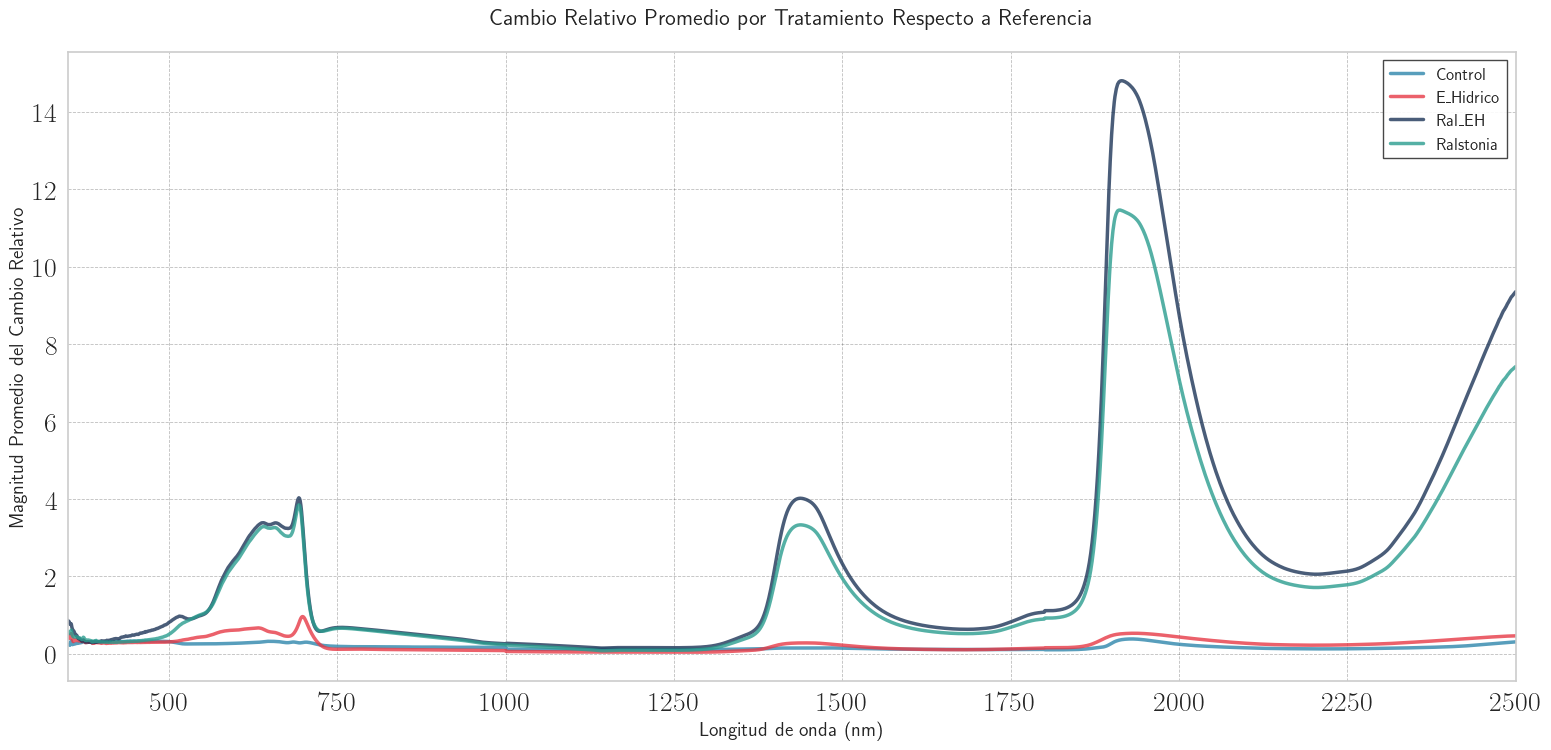

In [39]:
# Get the wavelengths (column names) and convert to float
wavelengths = df_means.iloc[:, 1:].columns.astype(float)

# Create the plot
plt.figure(figsize=(16, 8))

# Define colors for each treatment
colors = {
    'Control': '#2E86AB',
    'Tratamiento 1': '#A23B72',
    'Tratamiento 2': '#F18F01',
    'Tratamiento 3': '#6A994E',
    'Tratamiento 4': '#C73E1D'
}

# Plot each treatment
for treatment in df_means.index:
    magnitudes = df_means.loc[treatment].iloc[1:].values
    
    # Use predefined color if available, otherwise use default
    color = colors.get(treatment, None)
    
    plt.plot(wavelengths, magnitudes, 
             label=treatment, 
             linewidth=2.5, 
             alpha=0.8,
             color=color,) 

plt.xlabel('Longitud de onda (nm)', fontsize=14, fontweight='bold')
plt.ylabel('Magnitud Promedio del Cambio Relativo', fontsize=14, fontweight='bold')
plt.title('Cambio Relativo Promedio por Tratamiento Respecto a Referencia', 
          fontsize=16, fontweight='bold', pad=20)
plt.legend(fontsize=12, loc='best', framealpha=0.9)
plt.grid(True, alpha=0.3, linestyle='--')
plt.xlim(wavelengths.min(), wavelengths.max())
plt.tight_layout()
plt.show()

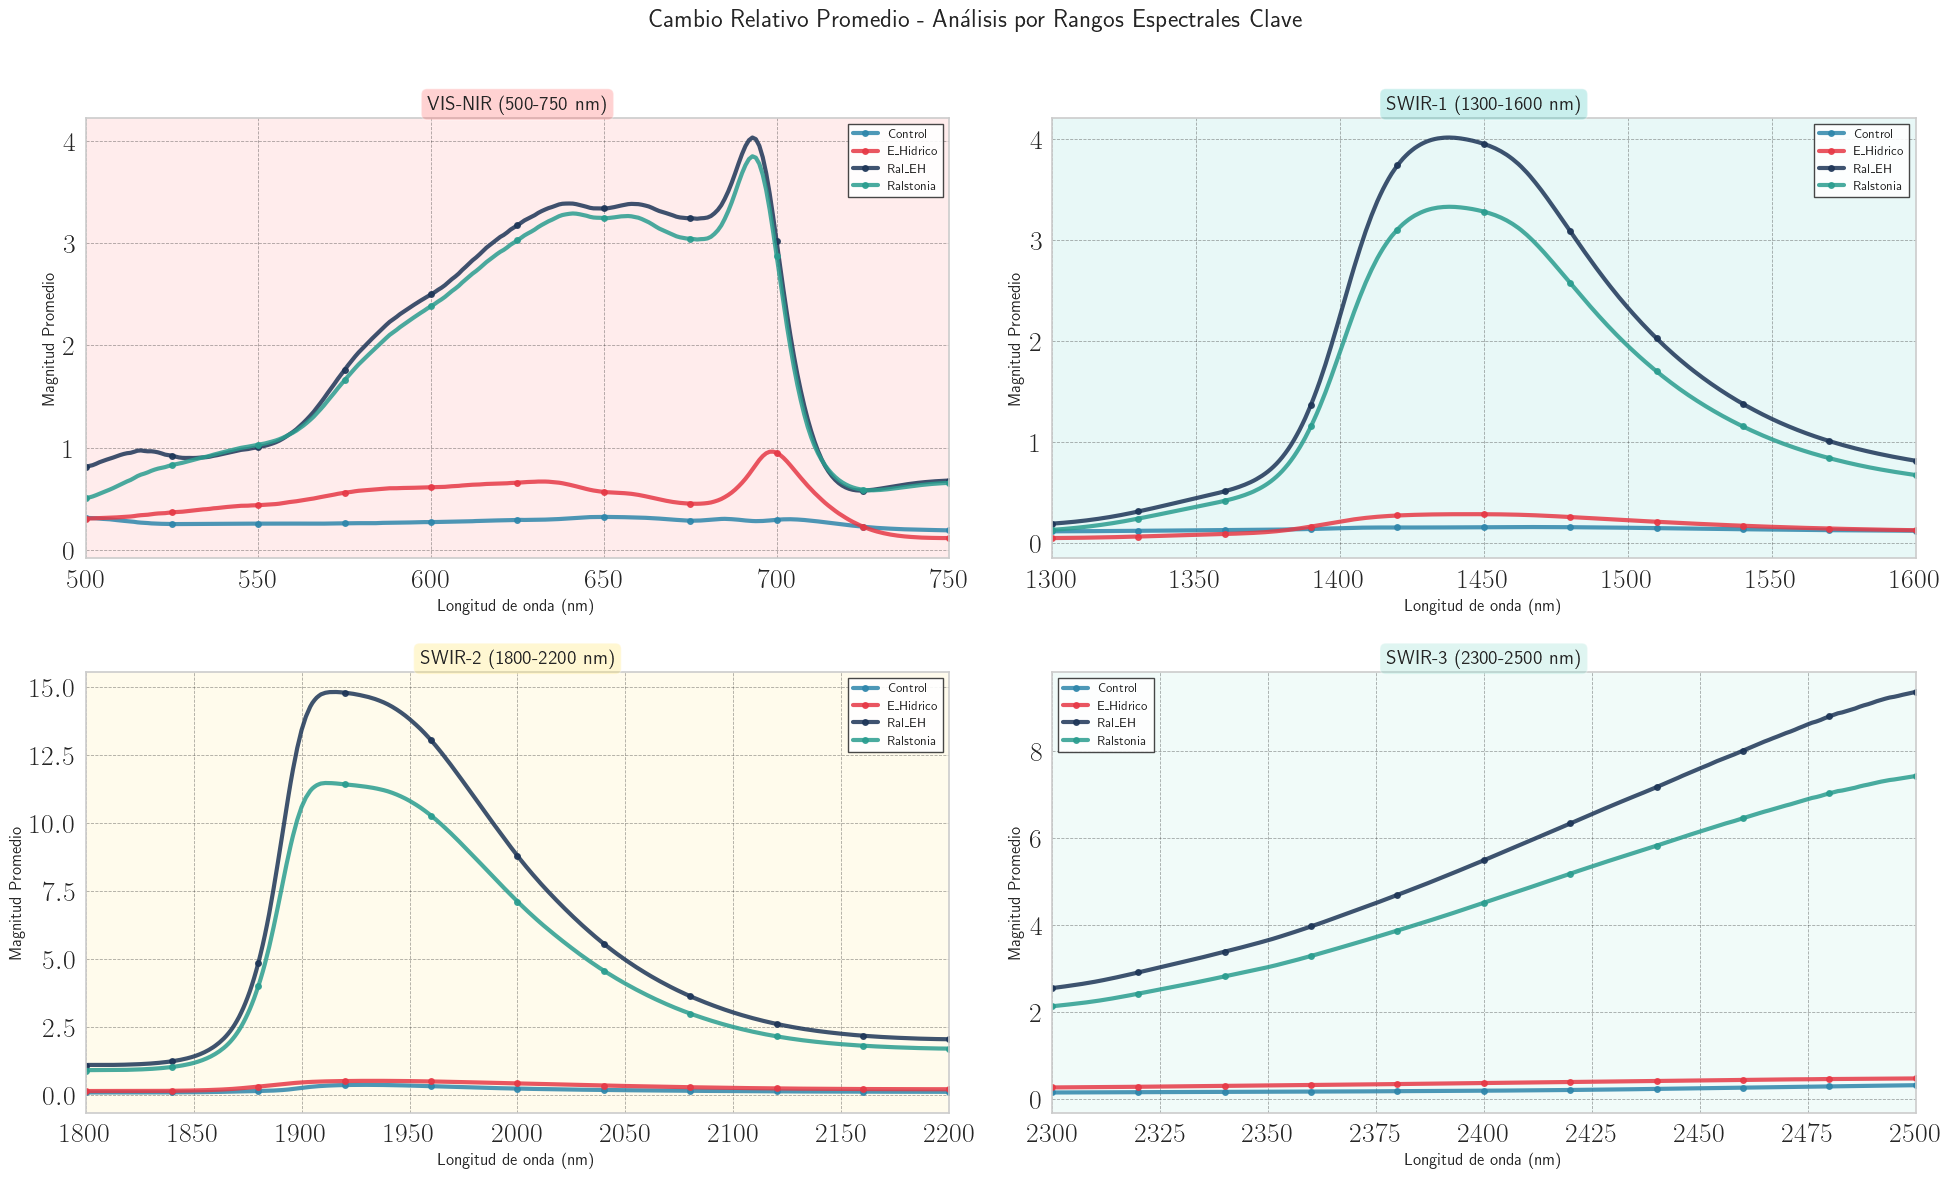

In [40]:
# Get the wavelengths (column names) and convert to float
wavelengths = df_means.iloc[:, 1:].columns.astype(float)

# Create subplots - one for each important range
fig = plt.figure(figsize=(20, 12))

# Define the important wavelength ranges
important_ranges = [
    (500, 750, '#FF6B6B', 'VIS-NIR (500-750 nm)'),
    (1300, 1600, '#4ECDC4', 'SWIR-1 (1300-1600 nm)'),
    (1800, 2200, '#FFE66D', 'SWIR-2 (1800-2200 nm)'),
    (2300, 2500, '#95E1D3', 'SWIR-3 (2300-2500 nm)')
]

# Define colors for each treatment
treatment_colors = {
    'Control': '#2E86AB',
    'Tratamiento 1': '#A23B72',
    'Tratamiento 2': '#F18F01',
    'Tratamiento 3': '#6A994E',
    'Tratamiento 4': '#C73E1D'
}

# Create 4 subplots for each range
for idx, (start, end, color, label) in enumerate(important_ranges, 1):
    ax = plt.subplot(2, 2, idx)
    
    # Filter wavelengths in this range
    mask = (wavelengths >= start) & (wavelengths <= end)
    range_wavelengths = wavelengths[mask]
    
    # Plot each treatment in this range
    for treatment in df_means.index:
        magnitudes = df_means.loc[treatment].iloc[1:].values
        range_magnitudes = magnitudes[mask]
        
        ax.plot(range_wavelengths, range_magnitudes,
                label=treatment,
                linewidth=3,
                alpha=0.85,
                color=treatment_colors.get(treatment),
                marker='o',
                markersize=4,
                markevery=max(1, len(range_wavelengths)//10))
    
    # Highlight the background
    ax.set_facecolor(color + '20')  # Add transparency
    
    ax.set_xlabel('Longitud de onda (nm)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Magnitud Promedio', fontsize=12, fontweight='bold')
    ax.set_title(label, fontsize=14, fontweight='bold', 
                 bbox=dict(boxstyle='round', facecolor=color, alpha=0.3))
    ax.legend(fontsize=9, loc='best', framealpha=0.9)
    ax.grid(True, alpha=0.4, linestyle='--')
    ax.set_xlim(start, end)

plt.suptitle('Cambio Relativo Promedio - Análisis por Rangos Espectrales Clave', 
             fontsize=18, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Decision trees

In [41]:
# Add column "Sana" with value 1 if Tratamiento is 'Control', else 0
df_all_magnitudes.insert(1, 'Sana', df_all_magnitudes['Tratamiento'].apply(lambda x: 1 if x == 'Control' else 0))


In [42]:
df_all_magnitudes.head()

,Tratamiento,Sana,Planta,350,351,352,353,354,355,356,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
0,Control,1,1,0.225961,0.201513,0.151999,0.148398,0.221836,0.295903,0.210691,...,0.223699,0.225517,0.234053,0.237269,0.241463,0.241699,0.236473,0.235315,0.234865,0.233316
1,Control,1,2,0.267812,0.269668,0.237224,0.240116,0.312360,0.360012,0.298656,...,0.215006,0.218186,0.225197,0.228544,0.234195,0.235769,0.231912,0.231772,0.232480,0.232131
2,Control,1,3,0.210672,0.190067,0.244476,0.190974,0.242460,0.338625,0.257720,...,0.266900,0.269969,0.276741,0.279090,0.284530,0.286613,0.281971,0.282949,0.288358,0.289175
3,Control,1,4,0.196482,0.198855,0.201164,0.243009,0.301320,0.314295,0.222382,...,0.244162,0.245556,0.246707,0.248910,0.253559,0.255028,0.256760,0.256129,0.251591,0.249593
4,Control,1,5,0.195880,0.211231,0.186891,0.161451,0.249826,0.292941,0.220676,...,0.272152,0.273466,0.274803,0.275729,0.277427,0.278149,0.278246,0.276410,0.272936,0.271555


Unique plants: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]

Train plants: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(17), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(25), np.int64(26), np.int64(27), np.int64(29), np.int64(30)]
Test plants: [28 16 24 18  9 10]

Train set size: 95 samples
Test set size: 24 samples
Train class distribution:
Sana
0    71
1    24
Name: count, dtype: int64
Test class distribution:
Sana
0    18
1     6
Name: count, dtype: int64

TRAINING SET PERFORMANCE
Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

     Enferma       1.00      1.00      1.00        71
        Sana       1.00      1.00      1.00        24

    accuracy                           1.00        95
   macro avg       1.00      1.

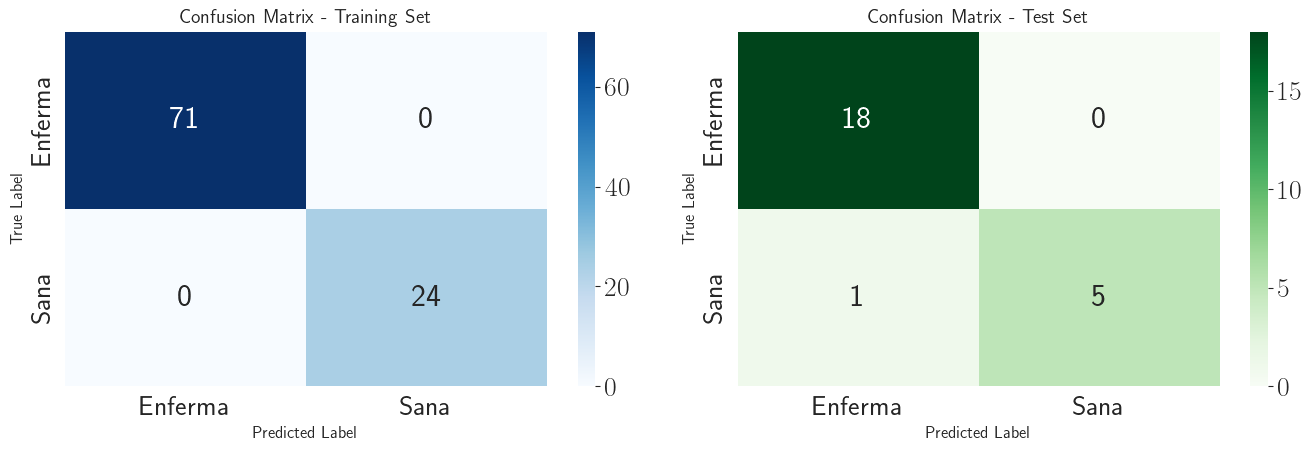

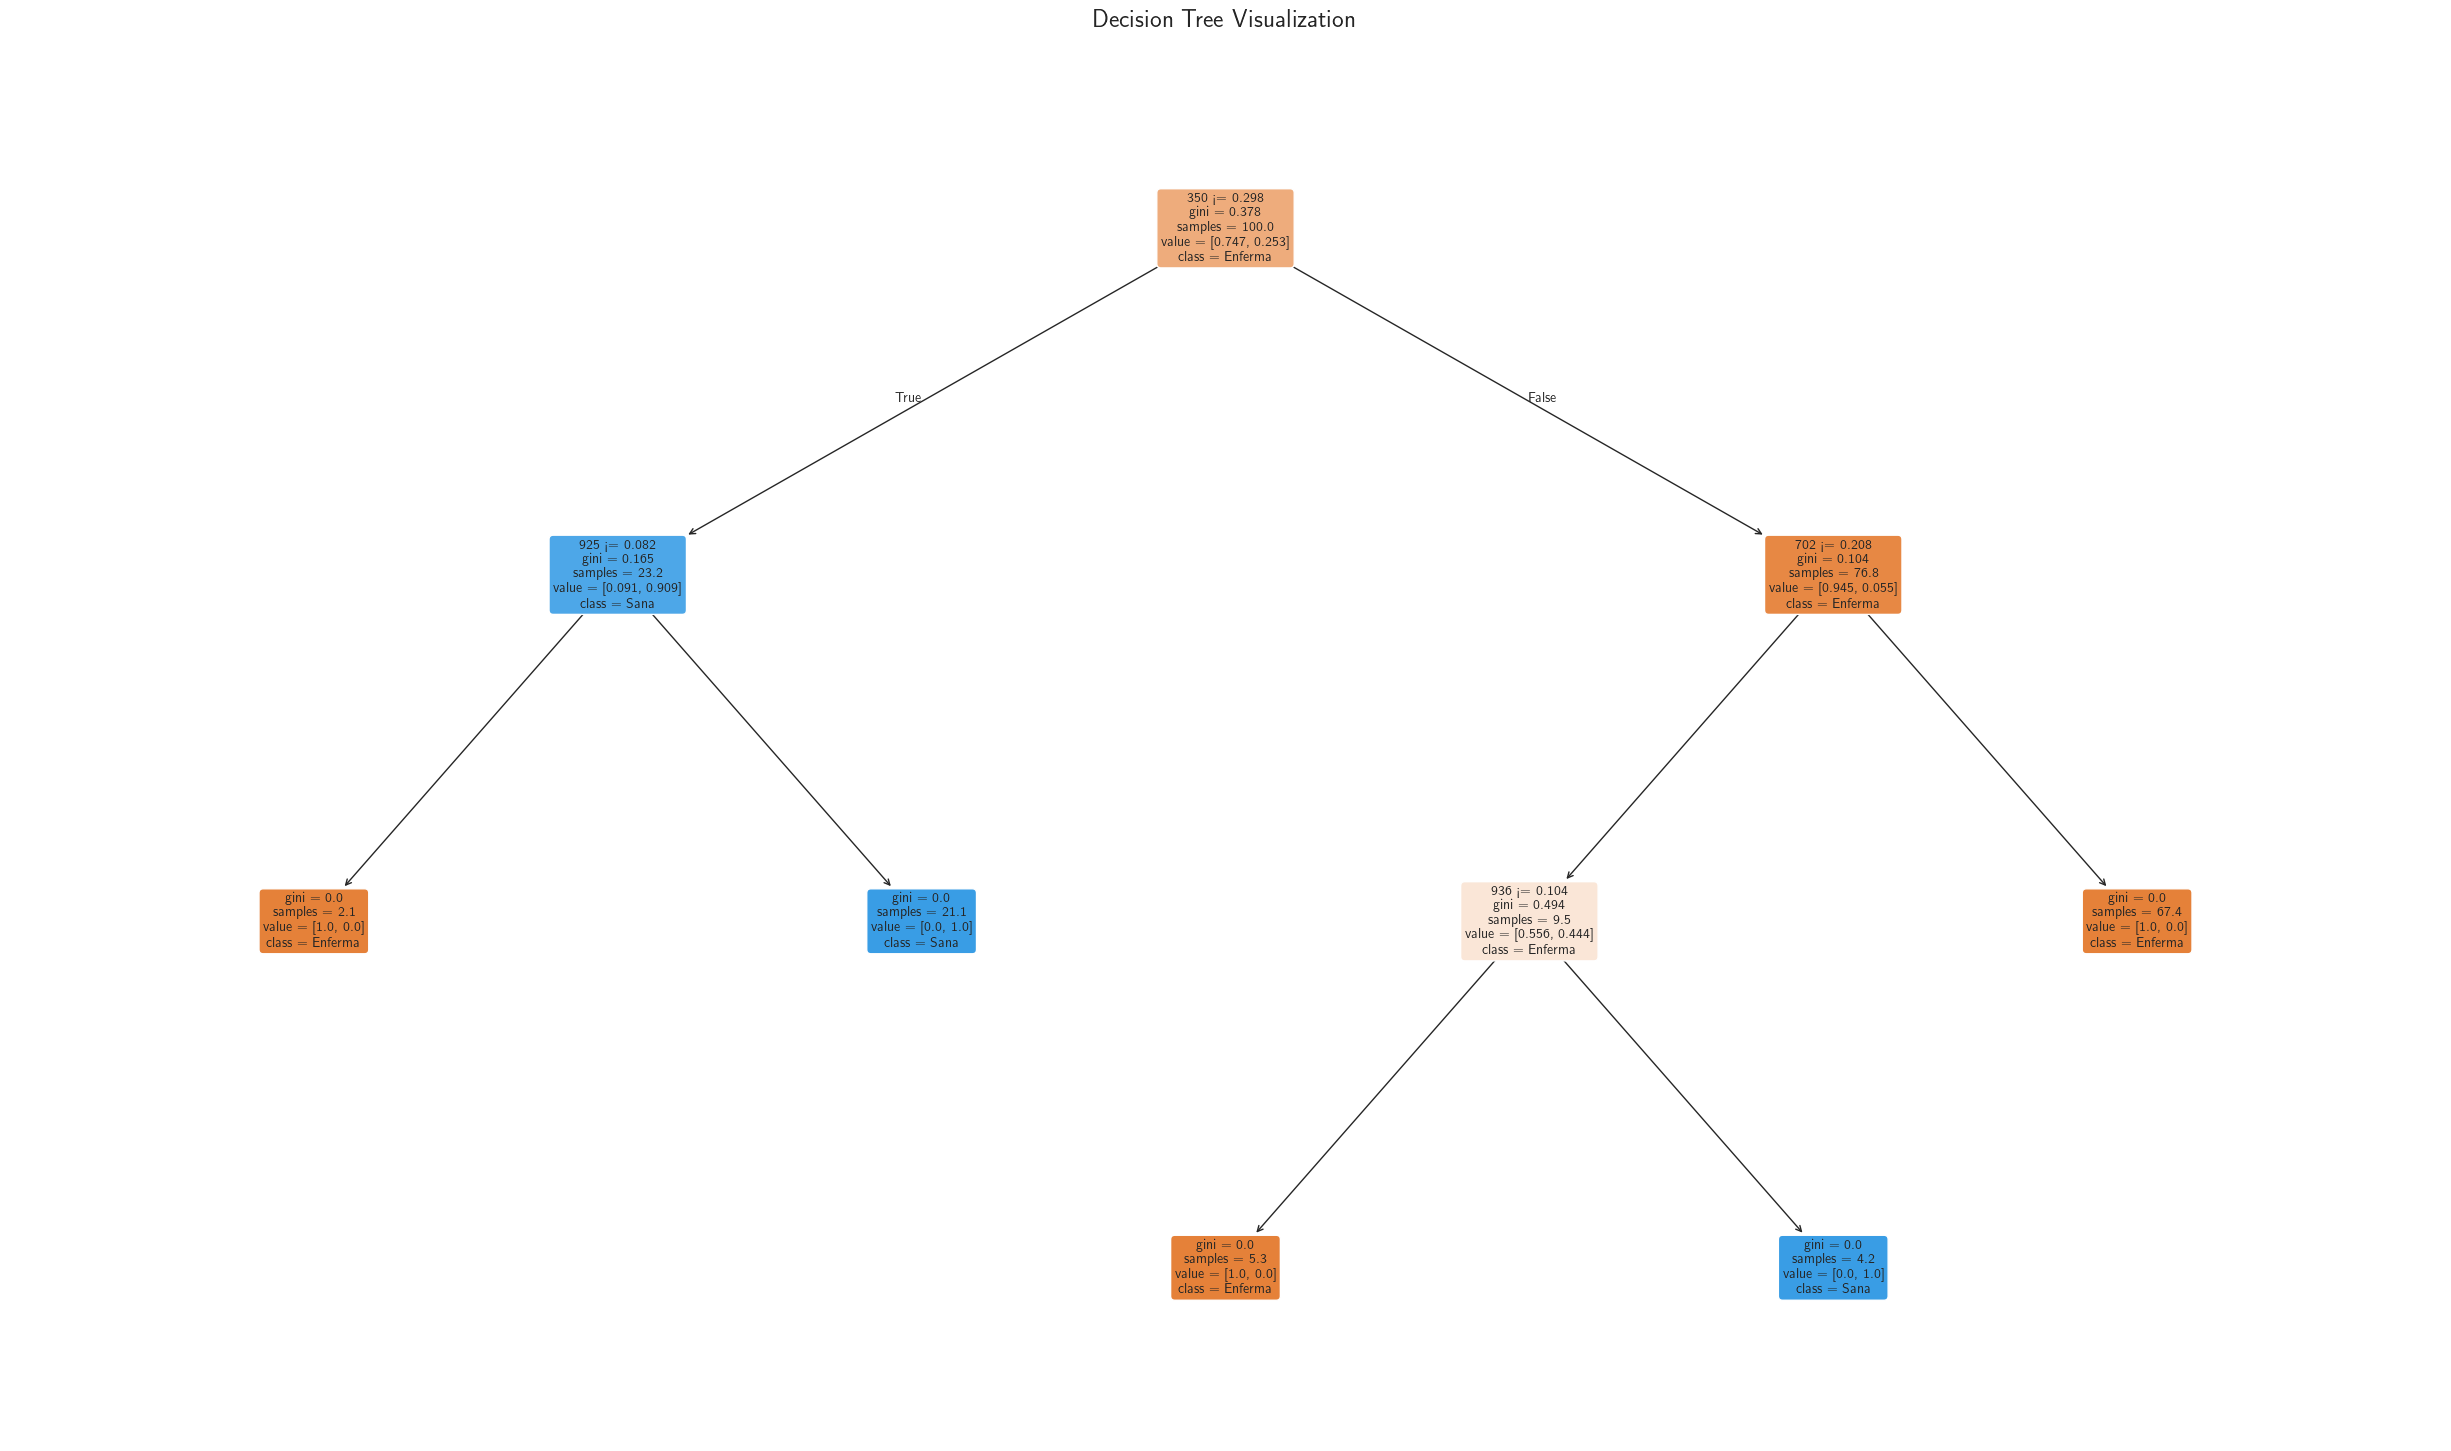


Top 20 Most Important Features:
     Feature  Importance
0        350    0.687849
586      936    0.123891
575      925    0.101366
352      702    0.086894
5        355    0.000000
6        356    0.000000
2119    2469    0.000000
22       372    0.000000
2135    2485    0.000000
2134    2484    0.000000
2        352    0.000000
2120    2470    0.000000
2121    2471    0.000000
2122    2472    0.000000
2123    2473    0.000000
2124    2474    0.000000
2125    2475    0.000000
2126    2476    0.000000
2127    2477    0.000000
2128    2478    0.000000


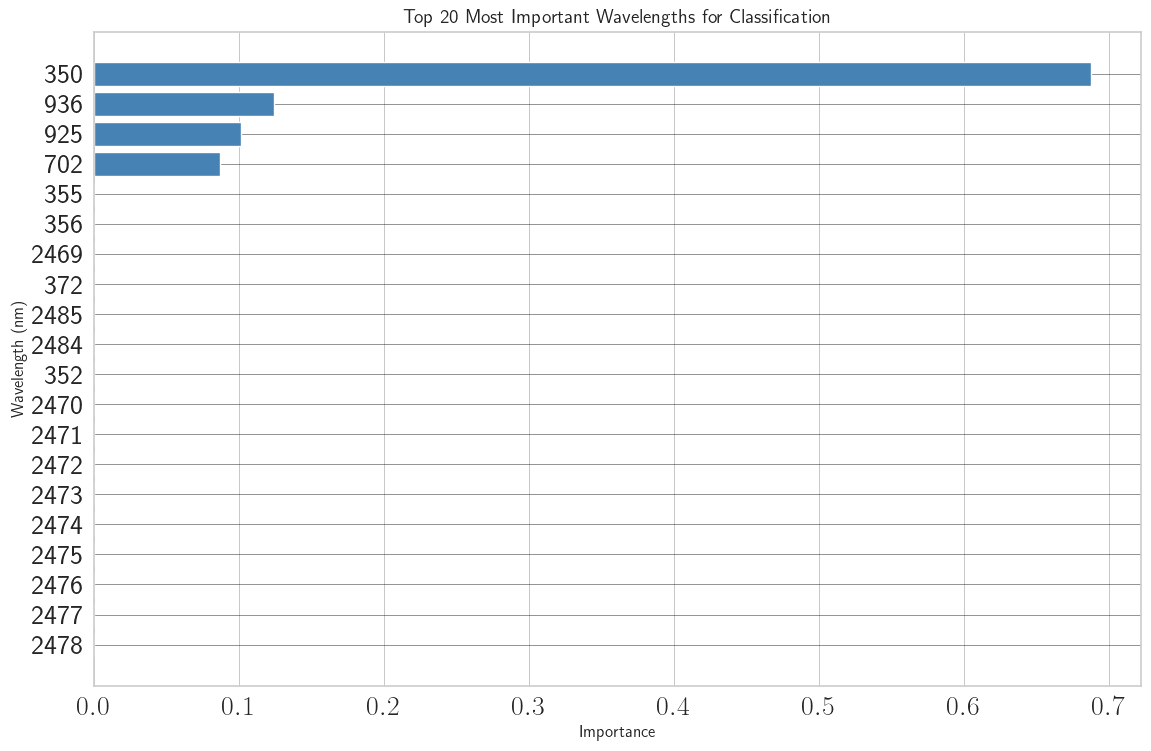

In [43]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Prepare the data
X = df_all_magnitudes.iloc[:, 3:]  # Features: from column 3 to the end
y = df_all_magnitudes['Sana']  # Target: Sana column

# Get unique plant indices
unique_plants = df_all_magnitudes['Planta'].unique()
print(f"Unique plants: {unique_plants}")

# Split plants into train and test (e.g., 80-20 split)
np.random.seed(42)
test_size = 0.2
n_test_plants = max(1, int(len(unique_plants) * test_size))
test_plants = np.random.choice(unique_plants, size=n_test_plants, replace=False)
train_plants = [p for p in unique_plants if p not in test_plants]

print(f"\nTrain plants: {train_plants}")
print(f"Test plants: {test_plants}")

# Create train and test sets based on plant indices
train_mask = df_all_magnitudes['Planta'].isin(train_plants)
test_mask = df_all_magnitudes['Planta'].isin(test_plants)

X_train = X[train_mask]
X_test = X[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]

print(f"\nTrain set size: {len(X_train)} samples")
print(f"Test set size: {len(X_test)} samples")
print(f"Train class distribution:\n{y_train.value_counts()}")
print(f"Test class distribution:\n{y_test.value_counts()}")

# Train the decision tree
dt_classifier = DecisionTreeClassifier(
    max_depth=5,  # Limit depth to avoid overfitting
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

dt_classifier.fit(X_train, y_train)

# Make predictions
y_pred_train = dt_classifier.predict(X_train)
y_pred_test = dt_classifier.predict(X_test)

# Evaluate the model
print("\n" + "="*50)
print("TRAINING SET PERFORMANCE")
print("="*50)
print(f"Accuracy: {accuracy_score(y_train, y_pred_train):.4f}")
print("\nClassification Report:")
print(classification_report(y_train, y_pred_train, target_names=['Enferma', 'Sana']))

print("\n" + "="*50)
print("TEST SET PERFORMANCE")
print("="*50)
print(f"Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test, target_names=['Enferma', 'Sana']))

# Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Train confusion matrix
cm_train = confusion_matrix(y_train, y_pred_train)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Enferma', 'Sana'], yticklabels=['Enferma', 'Sana'])
axes[0].set_title('Confusion Matrix - Training Set', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)

# Test confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['Enferma', 'Sana'], yticklabels=['Enferma', 'Sana'])
axes[1].set_title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.show()

# Visualize the decision tree
plt.figure(figsize=(25, 15))
plot_tree(dt_classifier, 
          filled=True, 
          feature_names=X.columns,
          class_names=['Enferma', 'Sana'],
          fontsize=10,
          rounded=True,
          proportion=True)
plt.title('Decision Tree Visualization', fontsize=18, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': dt_classifier.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 20 Most Important Features:")
print(feature_importance.head(20))

# Plot feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(20)
plt.barh(range(len(top_features)), top_features['Importance'].values, color='steelblue')
plt.yticks(range(len(top_features)), top_features['Feature'].values)
plt.xlabel('Importance', fontsize=12, fontweight='bold')
plt.ylabel('Wavelength (nm)', fontsize=12, fontweight='bold')
plt.title('Top 20 Most Important Wavelengths for Classification', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [44]:
# Lets take only the plant with illness Rasltonia number 7
df6_Con = df6[(df6['Planta'] == 7) & (df6['Tratamiento'] == 'Ralstonia')]
df7_Con = df7[(df7['Planta'] == 7) & (df7['Tratamiento'] == 'Ralstonia')]
df8_Con = df8[(df8['Planta'] == 7) & (df8['Tratamiento'] == 'Ralstonia')]
df12_Con = df12[(df12['Planta'] == 7) & (df12['Tratamiento'] == 'Ralstonia')]
df13_Con = df13[(df13['Planta'] == 7) & (df13['Tratamiento'] == 'Ralstonia')]
df14_Con = df14[(df14['Planta'] == 7) & (df14['Tratamiento'] == 'Ralstonia')]

# Combine all dataframes into a single dataframe
df_con = pd.concat([df6_Con, df7_Con, df8_Con, df12_Con, df13_Con, df14_Con]).reset_index(drop=True)


In [47]:
# Extract the relevant columns (from column 2 onwards)
data_cols = df_con.iloc[:, 2:]

# Calculate the magnitude for each column
magnitudes = []

for col in data_cols.columns:
    # Get the column values
    values = data_cols[col].values
    
    # Take the first value as reference (x)
    REF_value = REF[col]
    
    # Calculate |y-x|/x, |z-x|/x, etc. for all other values
    if REF_value != 0:  # Avoid division by zero
        differences = np.abs(values[1:] - REF_value)
        # Calculate the magnitude (Euclidean norm)
        magnitude = np.sqrt(np.sum(differences**2))
    else:
        magnitude = np.nan  # Handle zero reference value
    
    magnitudes.append(magnitude)

# Create a dataframe with one row containing all magnitudes
df_mag_RALS = pd.DataFrame([magnitudes], columns=data_cols.columns)

# Display the result
print(f"Shape of result: {df_mag_RALS.shape}")
df_mag_RALS.head()

Shape of result: (1, 2151)


,350,351,352,353,354,355,356,357,358,359,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
0,0.064686,0.062513,0.05255,0.05725,0.063257,0.062239,0.053369,0.044897,0.041621,0.043706,...,0.653866,0.653261,0.652512,0.652007,0.651508,0.651105,0.650983,0.650686,0.650264,0.649968


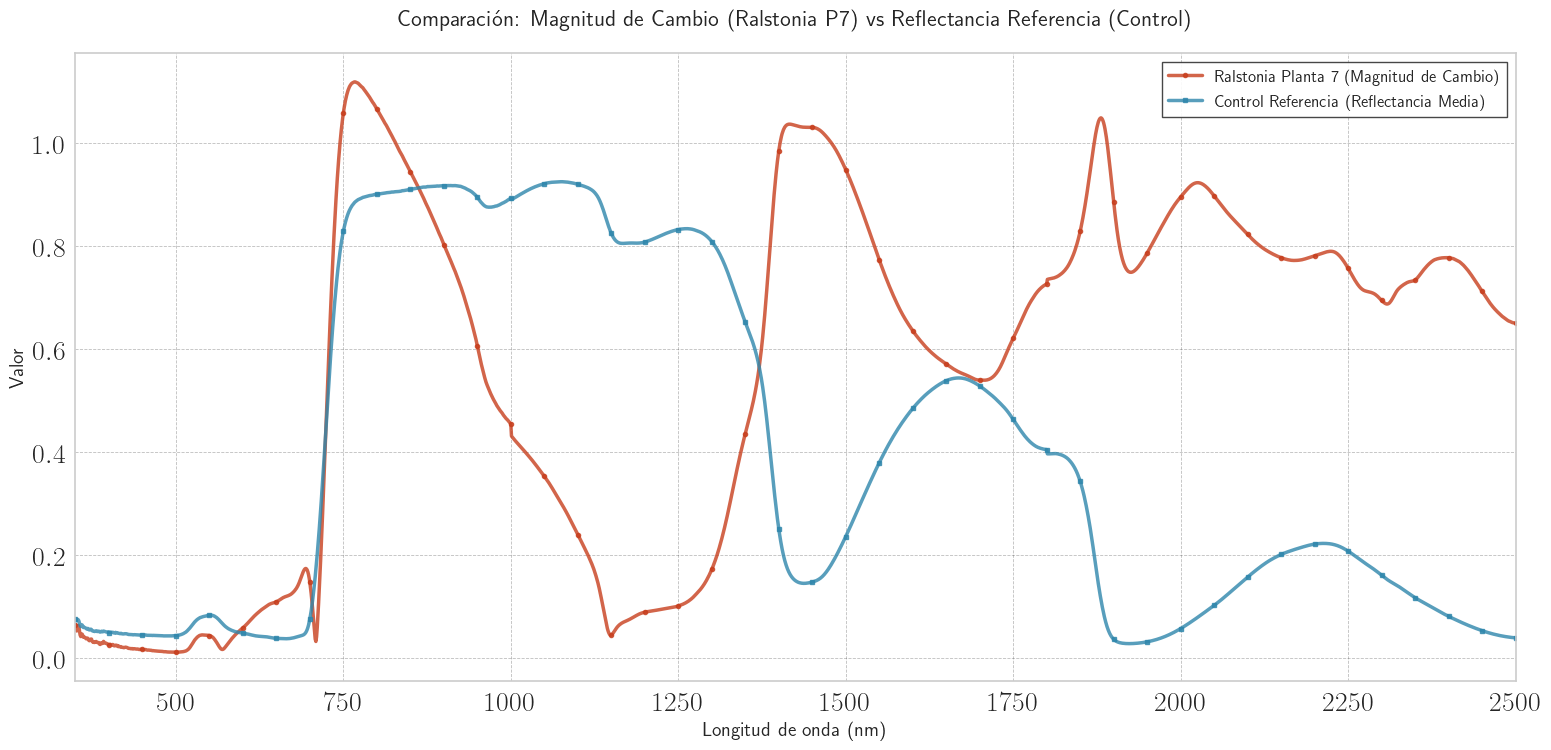


=== RALSTONIA PLANT 7 - MAGNITUDE STATISTICS ===
Mean: 0.5637
Std: 0.3410
Min: 0.0113 at 499.0 nm
Max: 1.1188 at 767.0 nm

=== CONTROL REFERENCE - REFLECTANCE STATISTICS ===
Mean: 0.3903
Std: 0.3351
Min: 0.0280 at 1923 nm
Max: 0.9250 at 1076 nm


In [48]:
# Get wavelengths and values
wavelengths = df_mag_RALS.columns.astype(float)
rals_values = df_mag_RALS.iloc[0].values
ref_values = REF.values

# Create the plot
plt.figure(figsize=(16, 8))

# Plot RALS magnitudes
plt.plot(wavelengths, rals_values, 
         label='Ralstonia Planta 7 (Magnitud de Cambio)', 
         linewidth=2.5, 
         alpha=0.8,
         color='#C73E1D',
         marker='o',
         markersize=3,
         markevery=50)

# Plot REF values
plt.plot(wavelengths, ref_values, 
         label='Control Referencia (Reflectancia Media)', 
         linewidth=2.5, 
         alpha=0.8,
         color='#2E86AB',
         marker='s',
         markersize=3,
         markevery=50)

plt.xlabel('Longitud de onda (nm)', fontsize=14, fontweight='bold')
plt.ylabel('Valor', fontsize=14, fontweight='bold')
plt.title('Comparación: Magnitud de Cambio (Ralstonia P7) vs Reflectancia Referencia (Control)', 
          fontsize=16, fontweight='bold', pad=20)
plt.legend(fontsize=12, loc='best', framealpha=0.9)
plt.grid(True, alpha=0.3, linestyle='--')
plt.xlim(wavelengths.min(), wavelengths.max())
plt.tight_layout()
plt.show()

# Print summary statistics
print("\n=== RALSTONIA PLANT 7 - MAGNITUDE STATISTICS ===")
print(f"Mean: {rals_values.mean():.4f}")
print(f"Std: {rals_values.std():.4f}")
print(f"Min: {rals_values.min():.4f} at {wavelengths[np.argmin(rals_values)]} nm")
print(f"Max: {rals_values.max():.4f} at {wavelengths[np.argmax(rals_values)]} nm")

print("\n=== CONTROL REFERENCE - REFLECTANCE STATISTICS ===")
print(f"Mean: {ref_values.mean():.4f}")
print(f"Std: {ref_values.std():.4f}")
print(f"Min: {ref_values.min():.4f} at {REF.idxmin()} nm")
print(f"Max: {ref_values.max():.4f} at {REF.idxmax()} nm")

In [51]:
# Create a list to store magnitudes for each day
all_daily_magnitudes = []

# Define the dataframes and their corresponding day labels
dataframes = [
    (df6_Con, 'Day 6'),
    (df7_Con, 'Day 7'),
    (df8_Con, 'Day 8'),
    (df12_Con, 'Day 12'),
    (df13_Con, 'Day 13'),
    (df14_Con, 'Day 14')
]

# Process each day's data
for df_day, day_label in dataframes:
    if len(df_day) > 0:  # Check if there's data for this day
        # Extract the relevant columns (from column 2 onwards)
        data_cols = df_day.iloc[:, 2:]
        
        # Calculate the magnitude for each wavelength column
        magnitudes = []
        
        for col in data_cols.columns:
            # Get the column values
            values = data_cols[col].values
            
            # Get the reference value from REF for this wavelength
            REF_value = REF[col]
            
            # Calculate |y-REF|/REF for all values
            if REF_value != 0:  # Avoid division by zero
                differences = np.abs(values - REF_value) 
                # Calculate the magnitude (Euclidean norm)
                magnitude = np.sqrt(np.sum(differences**2))
            else:
                magnitude = np.nan  # Handle zero reference value
            
            magnitudes.append(magnitude)
        
        # Create a row with day label and magnitudes
        row_data = {'Day': day_label, 'Planta': 7, 'Tratamiento': 'Ralstonia'}
        row_data.update({col: mag for col, mag in zip(data_cols.columns, magnitudes)})
        
        all_daily_magnitudes.append(row_data)

# Create the final dataframe with all daily magnitudes
df_daily_magnitudes = pd.DataFrame(all_daily_magnitudes)

# Display the result
print(f"Shape of result: {df_daily_magnitudes.shape}")
print(f"Days included: {df_daily_magnitudes['Day'].values}")
df_daily_magnitudes.head()

Shape of result: (6, 2154)
Days included: ['Day 6' 'Day 7' 'Day 8' 'Day 12' 'Day 13' 'Day 14']


,Day,Planta,Tratamiento,350,351,352,353,354,355,356,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
0,Day 6,7,Ralstonia,0.012194,0.012755,0.013576,0.013519,0.015659,0.017283,0.012355,...,0.003794,0.003748,0.003753,0.003774,0.003833,0.003879,0.004011,0.003938,0.003729,0.003639
1,Day 7,7,Ralstonia,0.014019,0.011361,0.013717,0.012548,0.010739,0.010163,0.011109,...,0.007892,0.007856,0.007817,0.007778,0.007747,0.007701,0.007616,0.007628,0.007680,0.007732
2,Day 8,7,Ralstonia,0.018276,0.019233,0.017787,0.017384,0.016730,0.015483,0.014207,...,0.003068,0.003025,0.002933,0.002954,0.003130,0.003191,0.003260,0.003287,0.003254,0.003215
3,Day 12,7,Ralstonia,0.031807,0.028388,0.024365,0.027325,0.030977,0.031013,0.025808,...,0.453373,0.453150,0.452880,0.452817,0.452831,0.452802,0.452980,0.453002,0.452822,0.452826
4,Day 13,7,Ralstonia,0.040275,0.040907,0.028965,0.035751,0.041028,0.038458,0.033937,...,0.289763,0.289250,0.288802,0.288309,0.287799,0.287394,0.287004,0.286667,0.286484,0.286143


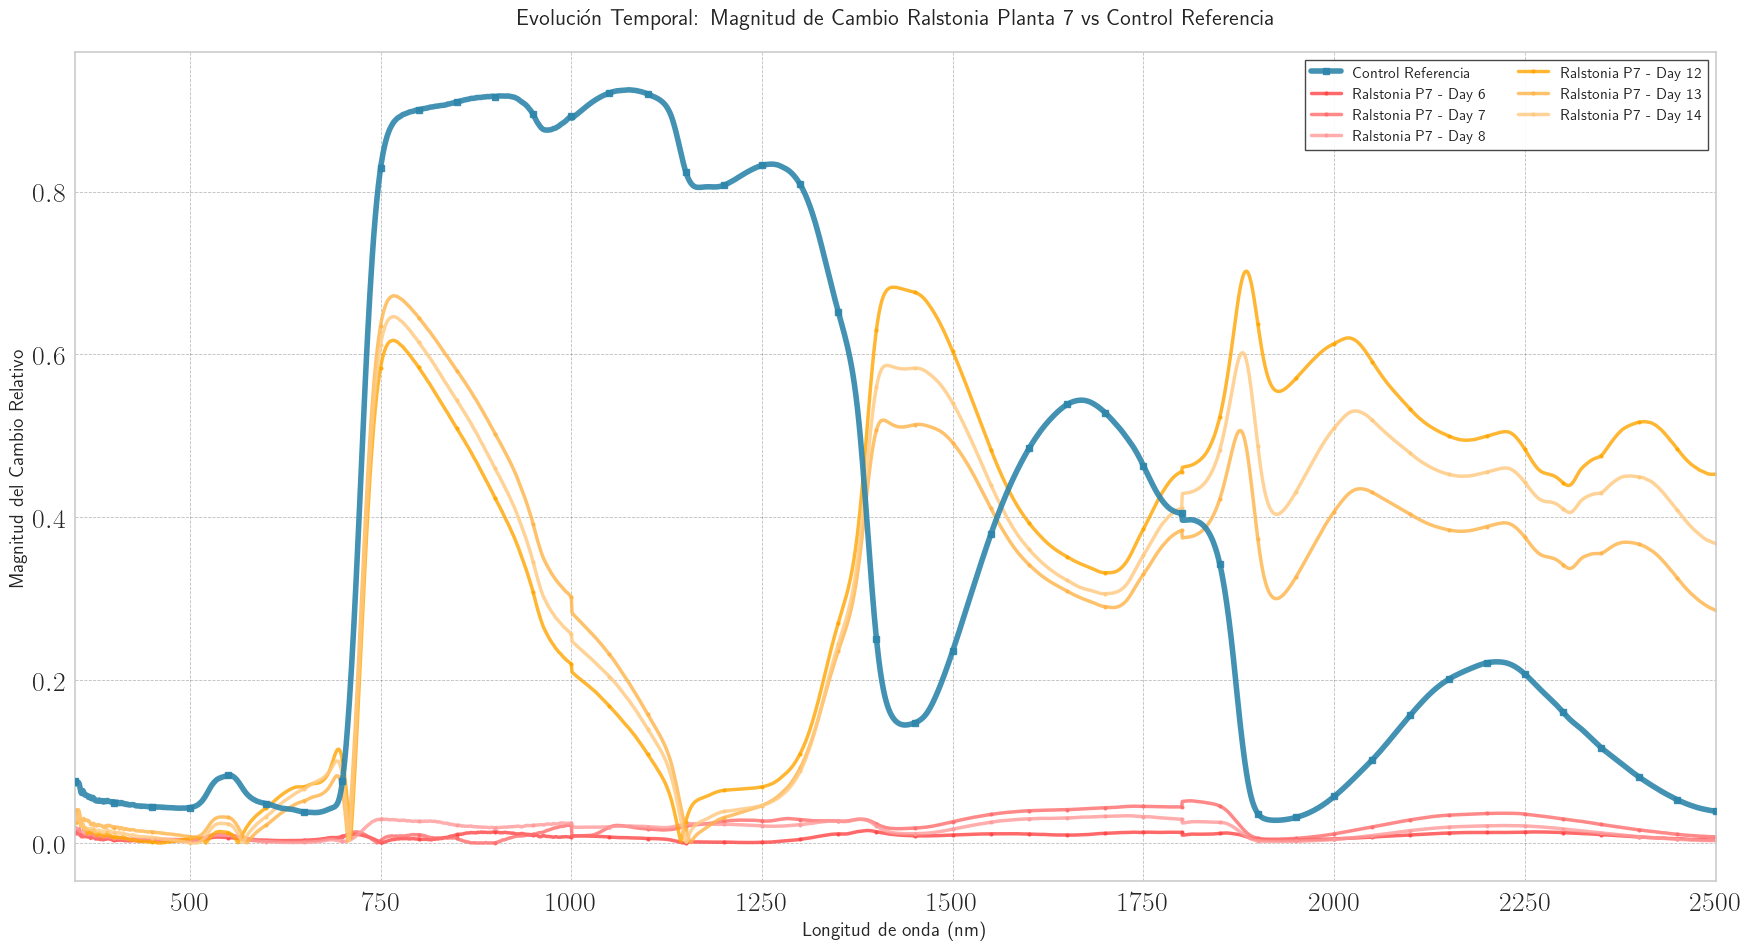


RESUMEN ESTADÍSTICO POR DÍA

Day 6:
  Media: 0.0080
  Desv. Est.: 0.0039
  Mínimo: 0.0000 @ 1147.0 nm
  Máximo: 0.0173 @ 355.0 nm

Day 7:
  Media: 0.0206
  Desv. Est.: 0.0136
  Mínimo: 0.0000 @ 884.0 nm
  Máximo: 0.0519 @ 1811.0 nm

Day 8:
  Media: 0.0170
  Desv. Est.: 0.0095
  Mínimo: 0.0007 @ 637.0 nm
  Máximo: 0.0336 @ 1728.0 nm

Day 12:
  Media: 0.3498
  Desv. Est.: 0.2198
  Mínimo: 0.0000 @ 458.0 nm
  Máximo: 0.7023 @ 1885.0 nm

Day 13:
  Media: 0.2951
  Desv. Est.: 0.1808
  Mínimo: 0.0002 @ 575.0 nm
  Máximo: 0.6721 @ 768.0 nm

Day 14:
  Media: 0.3218
  Desv. Est.: 0.1976
  Mínimo: 0.0000 @ 502.0 nm
  Máximo: 0.6465 @ 767.0 nm

CONTROL REFERENCIA
Media: 0.3903
Desv. Est.: 0.3352
Mínimo: 0.0280 @ 1923 nm
Máximo: 0.9250 @ 1076 nm


In [52]:
# Get wavelengths
wavelengths = df_daily_magnitudes.columns[3:].astype(float)

# Create the plot
plt.figure(figsize=(18, 10))

# Define colors for each day with a gradient from early to late
day_colors = {
    'Day 6': '#FF4444',   # Red
    'Day 7': '#FF6B6B',   # Light red
    'Day 8': '#FF9999',   # Lighter red
    'Day 12': '#FFA500',  # Orange
    'Day 13': '#FFB347',  # Light orange
    'Day 14': '#FFC97F'   # Lighter orange
}

# Plot REF (Control reference) - thicker line on top
plt.plot(wavelengths, REF.values, 
         label='Control Referencia', 
         linewidth=4, 
         alpha=0.9,
         color='#2E86AB',
         marker='s',
         markersize=4,
         markevery=50,
         zorder=10)

# Plot each day's magnitudes
for idx, row in df_daily_magnitudes.iterrows():
    day_label = row['Day']
    magnitudes = row.iloc[3:].values
    
    plt.plot(wavelengths, magnitudes,
             label=f'Ralstonia P7 - {day_label}',
             linewidth=2.5,
             alpha=0.8,
             color=day_colors.get(day_label, '#C73E1D'),
             marker='o',
             markersize=2,
             markevery=50)

plt.xlabel('Longitud de onda (nm)', fontsize=14, fontweight='bold')
plt.ylabel('Magnitud del Cambio Relativo', fontsize=14, fontweight='bold')
plt.title('Evolución Temporal: Magnitud de Cambio Ralstonia Planta 7 vs Control Referencia', 
          fontsize=16, fontweight='bold', pad=20)
plt.legend(fontsize=11, loc='best', framealpha=0.9, ncol=2)
plt.grid(True, alpha=0.3, linestyle='--')
plt.xlim(wavelengths.min(), wavelengths.max())
plt.tight_layout()
plt.show()

# Print summary statistics for each day
print("\n" + "="*70)
print("RESUMEN ESTADÍSTICO POR DÍA")
print("="*70)

for idx, row in df_daily_magnitudes.iterrows():
    day_label = row['Day']
    magnitudes = row.iloc[3:].values
    
    print(f"\n{day_label}:")
    print(f"  Media: {magnitudes.mean():.4f}")
    print(f"  Desv. Est.: {magnitudes.std():.4f}")
    print(f"  Mínimo: {magnitudes.min():.4f} @ {wavelengths[np.argmin(magnitudes)]} nm")
    print(f"  Máximo: {magnitudes.max():.4f} @ {wavelengths[np.argmax(magnitudes)]} nm")

print("\n" + "="*70)
print("CONTROL REFERENCIA")
print("="*70)
print(f"Media: {REF.mean():.4f}")
print(f"Desv. Est.: {REF.std():.4f}")
print(f"Mínimo: {REF.min():.4f} @ {REF.idxmin()} nm")
print(f"Máximo: {REF.max():.4f} @ {REF.idxmax()} nm")